# Worst-case OMP tests

In [4]:
import numpy as np
import scipy as sp
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import sys
sys.path.append("../../")
import pyApproxTools as pat
importlib.reload(pat)

%matplotlib inline

### Worst-case OMP algorithm

We construct a measurement basis $W_m$ based on a given approximation basis $V_n$. Our ambient space $V$ is $H_0^1([0,1])$. Here $V_n$ is the sinusoids, normalised in $H_0^1([0,1])$, so $V_n = \mathrm{span}\{\phi_1,\ldots,\phi_n\}$, where $\phi_k = \frac{\sqrt{2}}{\pi k} \sin(k \pi x)$.

The measurements are assumed to be point evaluations, which have representer in $H_0^1$ of
$$
\omega_{x_0}(x) = \frac{1}{\sqrt{x_0 (1-x_0)}}
\begin{cases}
x (1 - x_0) & \text{for } x \le x_0 \\
(1 - x) x_0 & \text{for } x > x_0
\end{cases}
$$

This implementation of the algorithm finds the vector $v\in V_n$ that is furthest possible from $W_m$, that is at each step we look for 
$$
v_k = argmax_{v\in V_n,\, \|v\|=1} \| v - P_{W_{k-1}} v \|
$$
and then find the dictionary element most closely aligned with this vector
$$
\omega_k 
= \mathrm{argmax}_{\omega\in\mathcal{D}} |\left\langle \omega, v_k - P_{W_{k-1}} v_k \right\rangle| 
$$
It is because of the selection of $v_k$ that we call this the _worst-case_ approach. We find $v_k$ through the SVD decomposition of the cross-gramian of $W_{k-1}$ and $V_n$. Although this is expensive, it works out quite well as the slowest part of the algorithm is actually the dot product search through $\mathcal{D}$, as the SVD code is written in 

### Lets look at $\beta(V_n, W_m)$ for our worst-case OMP basis and a random basis for comparison
Note that this calculation is done for a small dictionary that only has $N=10^3$ elements, to save time, however as we saw in the collective-OMP, the size of the dictionary doesn't have a huge impact in this example.

In [6]:
N = 1e3
dictionary = pat.make_unif_dictionary(N)

ns = [20,40]
np.random.seed(3)
#n = 20
m = 200
bs_comp = np.zeros((len(ns), m))
bs_wcomp = np.zeros((len(ns), m))
bs_rand = np.zeros((len(ns), m))

Vn = pat.make_sin_basis(ns[-1])
Wms_comp = []
Wms_wcomp = []
Wms_rand = []

for j, n in enumerate(ns):

    #gbc = pat.CollectiveOMP(dictionary, Vn.subspace(slice(0,n)), verbose=True)
    #Wm_comp = gbc.construct_to_m(m)
    #Wms_comp.append(Wm_comp)
    #Wm_comp_o = Wm_comp.orthonormalise()
    
    wcgbc = pat.WorstCaseOMP(dictionary, Vn.subspace(slice(0,n)), verbose=True)
    Wm_wcomp = wcgbc.construct_to_m(m)
    Wms_wcomp.append(Wm_wcomp)
    Wm_wcomp_o = Wm_wcomp.orthonormalise()

    Wm_rand = pat.make_random_delta_basis(m)
    Wms_rand.append(Wm_rand)
    Wm_rand_o = Wm_rand.orthonormalise()

    #BP_comp_l = pat.BasisPair(Wm_comp_o, Vn.subspace(slice(0,n)))
    BP_wcomp_l = pat.BasisPair(Wm_wcomp_o, Vn.subspace(slice(0,n)))    
    BP_rand_l = pat.BasisPair(Wm_rand_o, Vn.subspace(slice(0,n)))
    for i in range(n, m):
        #BP_comp = BP_comp_l.subspace(Wm_indices=slice(0,i))
        #bs_comp[j, i] = BP_comp.beta()

        BP_wcomp =  BP_wcomp_l.subspace(Wm_indices=slice(0,i))
        bs_wcomp[j, i] = BP_wcomp.beta()
        
        BP_rand = BP_rand_l.subspace(Wm_indices=slice(0,i))
        bs_rand[j, i] = BP_rand.beta()

i 	 || P_Vn (w - P_Wm w) ||
1 : 	 18 	 0.1535379542068806
2 : 	 69 	 0.23725663206188435
3 : 	 825 	 0.322581908262289
4 : 	 116 	 0.18747875804312494
5 : 	 274 	 0.34871987148815287
6 : 	 928 	 0.24208193260348262
7 : 	 372 	 0.24454226326855957
8 : 	 978 	 0.19039441583262495
9 : 	 166 	 0.20154268555130944
10 : 	 676 	 0.14632506003971363
11 : 	 553 	 0.1775816574510287
12 : 	 624 	 0.17542391100909402
13 : 	 213 	 0.1693791371831799
14 : 	 877 	 0.2770955984247552
15 : 	 423 	 0.2679966232564155
16 : 	 767 	 0.28051620132499555
17 : 	 322 	 0.2359328007312662
18 : 	 726 	 0.16580579661650952
19 : 	 463 	 0.1499893390367136
20 : 	 587 	 0.15291048834334442
21 : 	 242 	 0.11775307094605482
22 : 	 962 	 0.103373710836424
23 : 	 34 	 0.14962743187876412
24 : 	 797 	 0.09911943879506324
25 : 	 138 	 0.07624200910707235
26 : 	 525 	 0.08354190035810471
27 : 	 346 	 0.070636142534973
28 : 	 909 	 0.08076787503290529
29 : 	 649 	 0.08278455763346101
30 : 	 187 	 0.07091946101839597
31 : 	 

42 : 	 483 	 0.06417252536230068
43 : 	 68 	 0.05153382341036987
44 : 	 879 	 0.060875353840895235
45 : 	 344 	 0.08059573500449246
46 : 	 774 	 0.062524095583998
47 : 	 170 	 0.06964594753162374
48 : 	 596 	 0.044028817757188705
49 : 	 94 	 0.050038319058295325
50 : 	 672 	 0.044456946084490745
51 : 	 196 	 0.051617447529264726
52 : 	 455 	 0.03732194986776331
53 : 	 826 	 0.05945730460000813
54 : 	 271 	 0.04235113485172454
55 : 	 980 	 0.16304251840139722
56 : 	 398 	 0.03441871675502502
57 : 	 723 	 0.04458167190277075
58 : 	 145 	 0.044208509502787194
59 : 	 647 	 0.03872123523130767
60 : 	 904 	 0.04338718301327647
61 : 	 531 	 0.032456695385171534
62 : 	 223 	 0.06308579458829346
63 : 	 372 	 0.035166358031021513
64 : 	 801 	 0.059674607460850154
65 : 	 950 	 0.090458862301641
66 : 	 294 	 0.031743253426302076
67 : 	 624 	 0.038583339503476755
68 : 	 45 	 0.0651396326357723
69 : 	 697 	 0.04275433920874115
70 : 	 850 	 0.04066362578760984
71 : 	 552 	 0.03880768056030637
72 : 	 

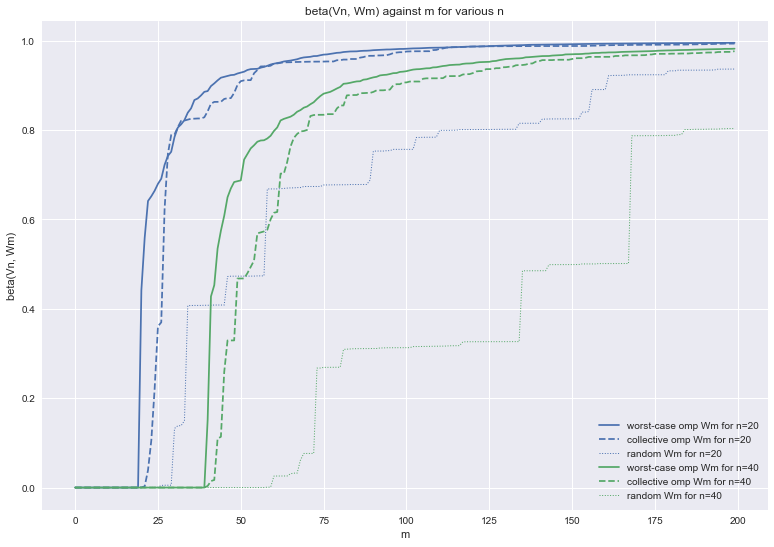

In [3]:
sns.set_palette("deep")
cp = sns.color_palette()

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title='beta(Vn, Wm) against m for various n')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')

for i, n in enumerate(ns):
    plt.plot(range(m), bs_wcomp[i, :], label='worst-case omp Wm for n={0}'.format(n), color=cp[i])#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))    
    plt.plot(range(m), bs_comp[i, :], '--', label='collective omp Wm for n={0}'.format(n), color=cp[i])#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))
    plt.plot(range(m), bs_rand[i, :], ':', label='random Wm for n={0}'.format(n), color=cp[i], lw=1)#r'Random $W_m$, $n={{{0}}}$'.format(n))

ax.set(xlabel='m', ylabel='beta(Vn, Wm)')#r'$m$', ylabel=r'$\beta(V_n, W_m)$')
plt.legend(loc=4)
plt.show()

In [4]:
bs_unif_int = np.zeros((len(ns), m))
Vn = pat.make_sin_basis(ns[-1])

Wms_unif_int = []

for j, n in enumerate(ns):
    for i in range(n, m):
        Wm_unif_int = pat.Basis([pat.FuncVector(params=[[x]],coeffs=[[1.0]],funcs=['H1UIDelta']) for x in np.linspace(0.0, 1.0, i, endpoint=False)+0.5/i])
        Wm_unif_int_o = Wm_unif_int.orthonormalise()

        BP_ui = pat.BasisPair(Wm_unif_int_o, Vn.subspace(slice(0,n)))
        bs_unif_int[j, i] = BP_ui.beta()

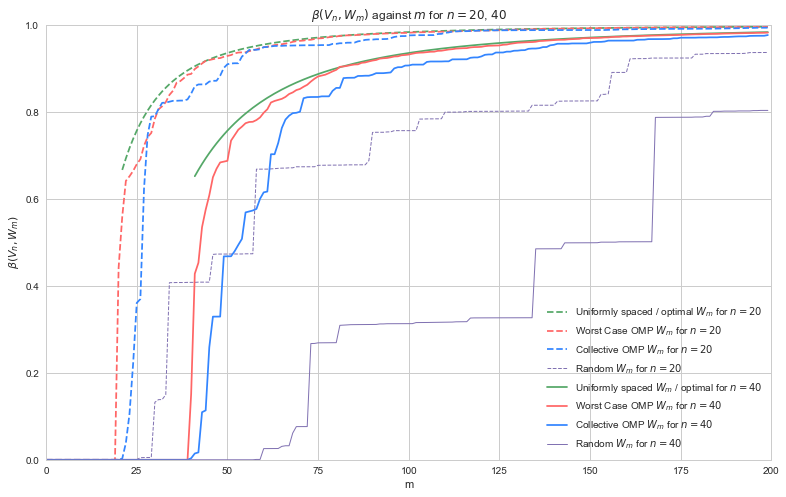

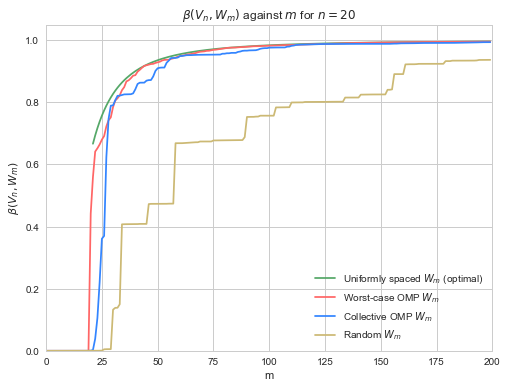

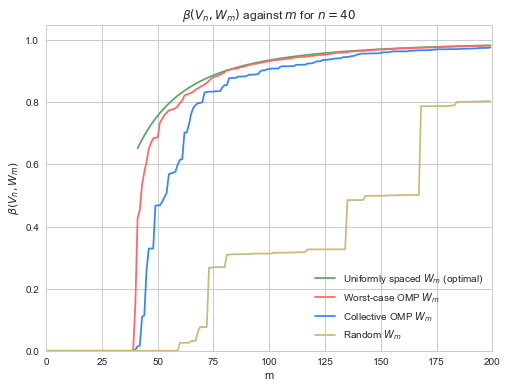

In [31]:
sns.set_palette("deep")
sns.set_style("whitegrid")
cp = sns.color_palette()

bl = (51/255, 133/255, 255/255)
re = (255/255, 102/255, 102/255)

axs = []
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n=20$, $40$')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')

#for i, n in enumerate(ns):
i=0
n=ns[i]
plt.plot(range(n+1,m), bs_unif_int[i, n+1:], '--', label=r'Uniformly spaced / optimal $W_m$ for $n={{{0}}}$'.format(n), color=cp[1])
plt.plot(range(m), bs_wcomp[i, :], '--', label=r'Worst Case OMP $W_m$ for $n={{{0}}}$'.format(n), color=re)#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))    
plt.plot(range(m), bs_comp[i, :], '--', label=r'Collective OMP $W_m$ for $n={{{0}}}$'.format(n), color=bl)#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))
plt.plot(range(m), bs_rand[i, :], '--', label=r'Random $W_m$ for $n={{{0}}}$'.format(n), color=cp[3], lw=1)#r'Random $W_m$, $n={{{0}}}$'.format(n))
i=1
n=ns[i]
plt.plot(range(n+1,m), bs_unif_int[i, n+1:], label=r'Uniformly spaced $W_m$ / optimal for $n={{{0}}}$'.format(n), color=cp[1])
plt.plot(range(m), bs_wcomp[i, :], label=r'Worst Case OMP $W_m$ for $n={{{0}}}$'.format(n), color=re)#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))    
plt.plot(range(m), bs_comp[i, :], label=r'Collective OMP $W_m$ for $n={{{0}}}$'.format(n), color=bl)#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))
plt.plot(range(m), bs_rand[i, :], label=r'Random $W_m$ for $n={{{0}}}$'.format(n), color=cp[3], lw=1)#r'Random $W_m$, $n={{{0}}}$'.format(n))

ax.set(xlabel='m', ylabel=r'$\beta(V_n, W_m)$', xlim=[0,200], ylim=[0,1])#r'$m$', ylabel=r'$\beta(V_n, W_m)$')
plt.legend(loc=4)
plt.savefig('WCOMPvsCOMPvsUnif.pdf')
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n=20$')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')

#for i, n in enumerate(ns):
i=0
n=ns[i]
plt.plot(range(n+1,m), bs_unif_int[i, n+1:], label=r'Uniformly spaced $W_m$ (optimal)'.format(n), color=cp[1])
plt.plot(range(m), bs_wcomp[i, :], label=r'Worst-case OMP $W_m$'.format(n), color=re)#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))    
plt.plot(range(m), bs_comp[i, :], label=r'Collective OMP $W_m$'.format(n), color=bl)#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))
plt.plot(range(m), bs_rand[i, :], label=r'Random $W_m$'.format(n), color=cp[4])#r'Random $W_m$, $n={{{0}}}$'.format(n))

ax.set(xlabel='m', ylabel=r'$\beta(V_n, W_m)$', xlim=[0,200], ylim=[0,1.05])#r'$m$', ylabel=r'$\beta(V_n, W_m)$')
plt.legend(loc=4)
plt.savefig('WCOMPvsCOMPvsUnif_20.pdf')
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n=40$')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')

i=1
n=ns[i]
plt.plot(range(n+1,m), bs_unif_int[i, n+1:], label=r'Uniformly spaced $W_m$ (optimal)'.format(n), color=cp[1])
plt.plot(range(m), bs_wcomp[i, :], label=r'Worst-case OMP $W_m$'.format(n), color=re)#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))    
plt.plot(range(m), bs_comp[i, :], label=r'Collective OMP $W_m$'.format(n), color=bl)#r'OMP constructed $W_m$, $n={{{0}}}$'.format(n))
plt.plot(range(m), bs_rand[i, :], label=r'Random $W_m$'.format(n), color=cp[4])#r'Random $W_m$, $n={{{0}}}$'.format(n))

ax.set(xlabel='m', ylabel=r'$\beta(V_n, W_m)$', xlim=[0,200], ylim=[0,1.05])#r'$m$', ylabel=r'$\beta(V_n, W_m)$')
plt.legend(loc=4)
plt.savefig('WCOMPvsCOMPvsUnif_40.pdf')
plt.show()

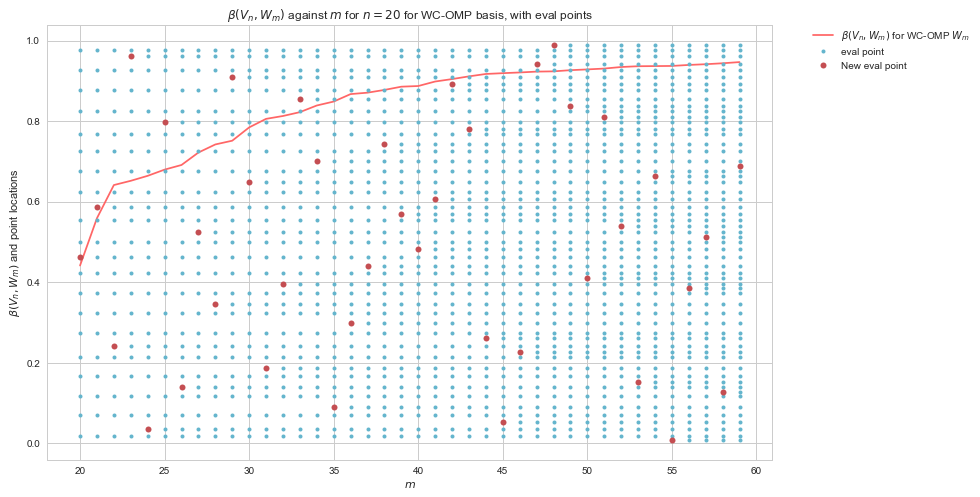

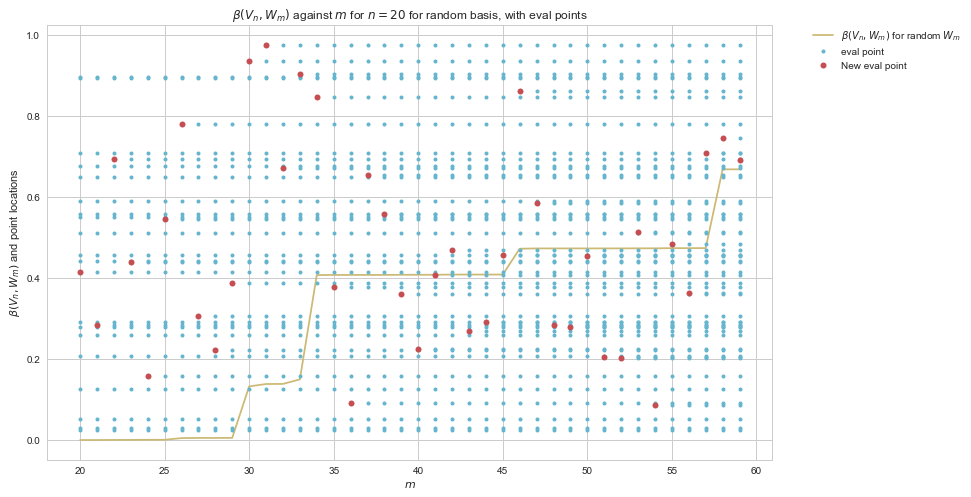

In [17]:
sns.set_palette("deep")
sns.set_style("whitegrid")
cp = sns.color_palette()

bl = (51/255, 133/255, 255/255)
re = (255/255, 102/255, 102/255)


# Plot the evaluation points in the Wm_rand basis 
# (note that the basis is infact orthonormalised so this isn't *quite* an accurate picture)
Wm_points = [vec.params_array(0)[0] for vec in Wms_wcomp[0].vecs]
n = ns[0]

axs = []
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n={{{0}}}$ for WC-OMP basis, with eval points'.format(n))
ax.set(xlabel=r'$m$', ylabel=r'$\beta(V_n, W_m)$ and point locations')
plt.plot(range(n,n+40), bs_wcomp[0,20:60], color=re, label=r'$\beta(V_n, W_m)$ for WC-OMP $W_m$')

plt.plot(n * np.ones(n-1), Wm_points[:n-1], 'o', color=cp[5], markersize=4, label='eval point')
plt.plot(n, Wm_points[n-1], 'o', color=cp[2], markersize=6, label='New eval point')
for m_plot in range(n, n+40-1):
    plt.plot((m_plot+1) * np.ones(m_plot), Wm_points[:m_plot], 'o', color=cp[5], markersize=4)
    plt.plot(m_plot+1, Wm_points[m_plot], 'o', color=cp[2], markersize=6)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('PointEvalLoc_WCOMP_20.pdf')
plt.show()


# Plot the evaluation points in the Wm_rand basis 
# (note that the basis is infact orthonormalised so this isn't *quite* an accurate picture)
Wm_points = [vec.params_array(0)[0] for vec in Wms_rand[0].vecs]

axs = []
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n={{{0}}}$ for random basis, with eval points'.format(n))
ax.set(xlabel=r'$m$', ylabel=r'$\beta(V_n, W_m)$ and point locations')
plt.plot(range(n,n+40), bs_rand[0,20:60], color=cp[4], label=r'$\beta(V_n, W_m)$ for random $W_m$')

plt.plot(n * np.ones(n-1), Wm_points[:n-1], 'o', color=cp[5], markersize=4, label='eval point')
plt.plot(n, Wm_points[n-1], 'o', color=cp[2], markersize=6, label='New eval point')
for m_plot in range(n, n+40-1):
    plt.plot((m_plot+1) * np.ones(m_plot), Wm_points[:m_plot], 'o', color=cp[5], markersize=4)
    plt.plot(m_plot+1, Wm_points[m_plot], 'o', color=cp[2], markersize=6)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('PointEvalLoc_rand_20.pdf')
plt.show()


### Fix a minimum $\beta^*$ and vary $n$, plot resulting $m^*$

This result is actually found using the script ```scripts/01_m_star_tests.py``` and the accompanying ```make_01_scripts.py``` which produces the batch job for cluster computers. Here we just import the results which are found in csv files imported from the computing cluster.

Note that this, at present, is for the value $\beta^* = 0.5$.

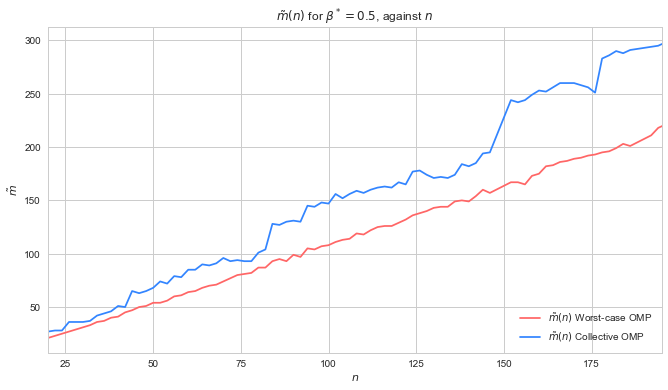

In [7]:
data_dir = '../../scripts/omp/'
comp_file = data_dir + 'comp_sin_m_star.csv'
wcomp_file = data_dir + 'wcomp_sin_m_star.csv'

ms_comp = np.loadtxt(comp_file)
ms_wcomp = np.loadtxt(wcomp_file)

sns.set_palette("deep")
sns.set_style("whitegrid")
cp = sns.color_palette()

bl = (51/255, 133/255, 255/255)
re = (255/255, 102/255, 102/255)

axs = []
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1, title=r'$\tilde{m}(n)$ for $\beta^*=0.5$, against $n$')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')

plt.plot(ms_wcomp[:,0], ms_wcomp[:,1], label=r'$\tilde{m}(n)$ Worst-case OMP', color=re)
plt.plot(ms_comp[:,0], ms_comp[:,1], label=r'$\tilde{m}(n)$ Collective OMP', color=bl)

ax.set(xlabel='$n$', ylabel=r'$\tilde{m}$', xlim=[20,195])#r'$m$', ylabel=r'$\beta(V_n, W_m)$')
ax.xaxis.set_ticks(np.arange(25, 200, 25))
plt.legend(loc=4)
plt.savefig('m_star_COMP_vs_WCOMP.pdf')
plt.show()


### Fix a minimum $\beta^*$ and find resulting $m^*$ with an incremental $V_n$

That is, for a given $n$, say we have found $m^*(n)$ and we have corresponding $W_{m^*(n)}$, then what is the $m^*(n+1)$ if we *keep* $W_{m^*(n)}$ and use OMP to find the next few measurements to satisfy $\beta(V_{n+1}, W_{m^*(n_1)}) > \beta$?

This result is actually found using the script ```scripts/03_m_n_incremental.py```. Here we just import the results which are found in csv files imported from the computing cluster.

Again we have the value $\beta^* = 0.5$.

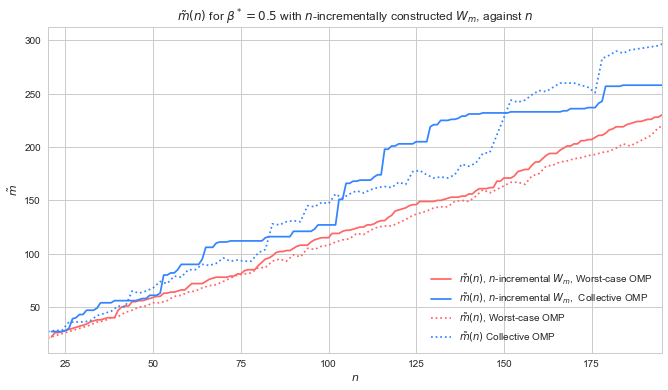

In [11]:
data_dir = '../../scripts/omp/'
comp_file = data_dir + 'comp_sin_n_incr_m_star.csv'
wcomp_file = data_dir + 'wcomp_sin_n_incr_m_star.csv'

ms_nincr_comp = np.loadtxt(comp_file)
ms_nincr_wcomp = np.loadtxt(wcomp_file)

sns.set_palette("deep")
sns.set_style("whitegrid")
cp = sns.color_palette()

bl = (51/255, 133/255, 255/255)
re = (255/255, 102/255, 102/255)

axs = []
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1, title=r'$\tilde{m}(n)$ for $\beta^*=0.5$ with $n$-incrementally constructed $W_m$, against $n$')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')

plt.plot(ms_nincr_wcomp[:,0], ms_nincr_wcomp[:,1], label=r'$\tilde{m}(n)$, $n$-incremental $W_m$, Worst-case OMP', color=re)
plt.plot(ms_nincr_comp[:,0], ms_nincr_comp[:,1], label=r'$\tilde{m}(n)$, $n$-incremental $W_m$,  Collective OMP', color=bl)

plt.plot(ms_wcomp[:,0], ms_wcomp[:,1], ':', label=r'$\tilde{m}(n)$, Worst-case OMP', color=re)
plt.plot(ms_comp[:,0], ms_comp[:,1], ':', label=r'$\tilde{m}(n)$ Collective OMP', color=bl)

ax.set(xlabel='$n$', ylabel=r'$\tilde{m}$', xlim=[20,195])#r'$m$', ylabel=r'$\beta(V_n, W_m)$')
ax.xaxis.set_ticks(np.arange(25, 200, 25))
plt.legend(loc=4)
plt.savefig('n_incr_COMP_vs_WCOMP.pdf')
plt.show()
